Mean Squared Error (KNN, k=5): 72076878052960.0625
     Actual Salary  Predicted Salary
366      2120693.0      2.555436e+06
155      9890000.0      1.372623e+07
313      3510480.0      5.064466e+06
269      6166667.0      3.917018e+06
221     12654321.0      4.118117e+06
..             ...               ...
367      1891857.0      2.483304e+06
235      6133005.0      4.322168e+06
237      3989122.0      5.224792e+06
343      2087519.0      4.342224e+06
56      11424600.0      2.200814e+07

[76 rows x 2 columns]


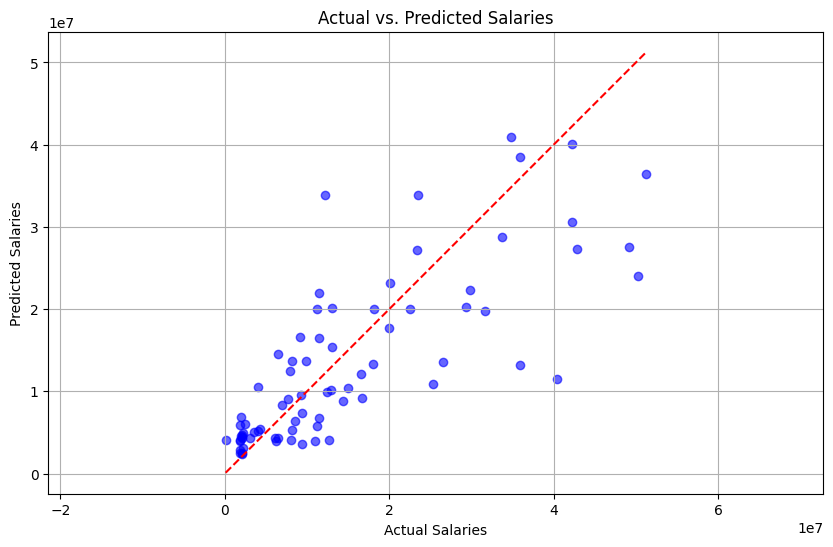

In [16]:
# Predicting using KNN
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the overall data
# data = pd.read_csv('nba_data.csv')
# Load the data per game
data = pd.read_csv('nba_dataPG.csv')


# Split the data into features and target
features = ['FG', '3P','TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']
X= data[features]
y = data['Salary']

# Scale the feature data (important for KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# Create the KNN regressor model with Euclidean distance (default metric)
knn = KNeighborsRegressor(n_neighbors=8, metric='manhattan')

# Fit the model
knn.fit(X_train, y_train)

# Predict salaries on the test set
y_pred = knn.predict(X_test)

# Evaluate the performance using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (KNN, k=5): {mse:.4f}')

# Create a DataFrame to display the actual vs. predicted values
results_df = pd.DataFrame({'Actual Salary': y_test, 'Predicted Salary': y_pred})

# Display the results DataFrame
print(results_df)

# Plotting Actual vs. Predicted Salaries
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Ideal line
plt.title('Actual vs. Predicted Salaries')
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.grid()
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.axis('equal')  # Equal scaling for both axes
plt.show()

In [12]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_csv('nba_dataPG.csv')

# Select features for comparison
features = ['FG', '3P', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']
X = data[features]

# Scale the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create the NearestNeighbors model
nn = NearestNeighbors(n_neighbors=6, metric='euclidean')  # 6 because it includes the player itself
nn.fit(X_scaled)

def get_similar_players(player_name, k=5):
    if player_name not in data['Player'].values:
        return "Player not found in the dataset."
    
    player_index = data[data['Player'] == player_name].index[0]
    player_stats = X_scaled[player_index].reshape(1, -1)
    player_position = data.loc[player_index, 'Pos']
    
    # Get all neighbors
    distances, indices = nn.kneighbors(player_stats, n_neighbors=len(data))
    
    # Filter players by position
    similar_players = data.iloc[indices[0]]
    similar_players = similar_players[similar_players['Pos'] == player_position]
    
    # Exclude the player himself and get top k
    similar_players = similar_players[similar_players['Player'] != player_name].head(k)
    
    result = pd.DataFrame({
        'Similar Player': similar_players['Player'],
        'Distance': distances[0][indices[0] != player_index][:k],
        'Team': similar_players['Team'],
        'Position': similar_players['Pos']
    })
    
    return result.sort_values('Distance')

# Example usage
player_name = "LeBron James"  # Replace with any player name in your dataset
similar_players = get_similar_players(player_name)
print(f"Players most similar to {player_name}:")
print(similar_players)

# Function to get player comparisons for all players
def get_all_player_comparisons(data, k=5):
    all_comparisons = {}
    for player in data['Player']:
        comparisons = get_similar_players(player, k)
        all_comparisons[player] = comparisons
    return all_comparisons

# Get comparisons for all players
all_player_comparisons = get_all_player_comparisons(data)

# Example: Print comparisons for a specific player
print(all_player_comparisons["Keldon Johnson"])

Players most similar to LeBron James:
     Similar Player  Distance Team Position
15   Paolo Banchero  1.685629  ORL       PF
7      Jayson Tatum  1.749393  BOS       PF
6      Kevin Durant  1.862536  PHO       PF
80    Julius Randle  1.922968  NYK       PF
24  Zion Williamson  1.935267  NOP       PF
         Similar Player  Distance Team Position
112     De'Andre Hunter  0.946929  ATL       SF
126  Bennedict Mathurin  1.052690  IND       SF
122          Saddiq Bey  1.070877  ATL       SF
56       Brandon Miller  1.109123  CHO       SF
127           Max Strus  1.234282  CLE       SF


In [17]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Log-transform the target variable
y = np.log(data['Salary'])

# Scale features and split data
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# Try Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Random Forest): {mse:.4f}')

# Cross-validation for more robust evaluation
cv_scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated MSE: {-cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})')

# Convert predictions back to original scale
results_df = pd.DataFrame({
    'Actual Salary': np.exp(y_test),
    'Predicted Salary': np.exp(y_pred)
})
print(results_df)

Mean Squared Error (Random Forest): 0.5710
Cross-validated MSE: 0.5096 (+/- 0.1836)
     Actual Salary  Predicted Salary
366      2120693.0      2.401726e+06
155      9890000.0      1.031466e+07
313      3510480.0      4.246451e+06
269      6166667.0      3.272331e+06
221     12654321.0      3.722498e+06
..             ...               ...
367      1891857.0      2.210073e+06
235      6133005.0      4.585027e+06
237      3989122.0      4.206729e+06
343      2087519.0      3.430358e+06
56      11424600.0      1.822261e+07

[76 rows x 2 columns]


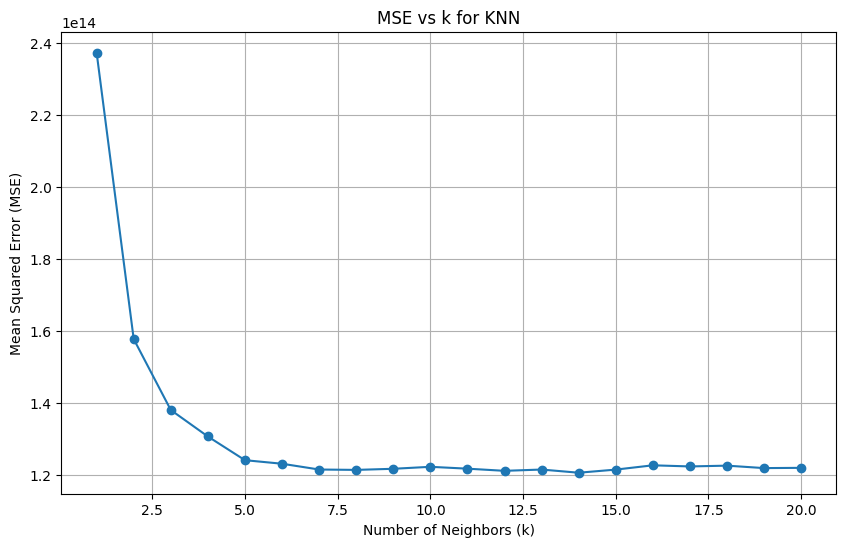

In [7]:
from sklearn.model_selection import cross_val_score
k_values = range(1, 21)  # Test k values from 1 to 20
mse_values = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    mse = -cross_val_score(knn, X_scaled, y, cv=5, scoring='neg_mean_squared_error').mean()
    mse_values.append(mse)

# Plot MSE vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, mse_values, marker='o')
plt.title('MSE vs k for KNN')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid()
plt.show()